In [1]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

class Augmentation():
    '''
    Input format:
        image : list of image
        xml : list of xml
        classes : list of class name, ex : [coating_Particle, Mask, ...]
        imPath : path for saving new images
        xmlPath : path for saving new xmls
        saveName : New images and xmls file name
    '''    
    def __init__(self, image, xml, classes, saveName, imPath, xmlPath):
        self.image = image
        self.xml = xml
        self.classes = classes
        self.saveName = saveName
        self.imPath = imPath
        self.xmlPath = xmlPath
        
    def _saveImage(self, image, fileName):
        Suffix = '.jpg'
        Path = os.path.join(self.imPath, fileName + Suffix)
        success = cv2.imwrite(Path, image)
        if not success:
            raise Exception('Image Saving Error! Please check your image or save dir.')
            
    def _saveXML(self, xml, fileName):
        Suffix = '.xml'
        Path = os.path.join(self.xmlPath, fileName + Suffix)
        xml.write(Path)
    

    def _XmlInfo(self, tree):
        root = tree.getroot()
        boxSet = []
        if root.find('size'):
            size = root.find('size')
            w = int(size.find('width').text)    
            h = int(size.find('height').text)   

            for obj in root.iter('object'):

                difficult = obj.find('difficult').text
                cls = obj.find('name').text

                if cls not in self.classes or int(difficult)==1:
                    continue
                cls_id = self.classes.index(cls)
                xmlbox = obj.find('bndbox')
       
                b = [float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text)]
                boxSet.append(b)
        return boxSet
    
    def _checkBox(self, w, h, box, new):
        if new[0] < 0:
            new[0] = 0
        if new[1] >= w:
            new[1] = w - 1
        if new[2] < 0:
            new[2] = 0
        if new[3] >= h:
            new[3] = h - 1
        boxArea = (box[3] - box[2]) * (box[1] - box[0])
        newArea = (new[3] - new[2]) * (new[1] - new[0])
        if newArea / boxArea < 0.3 :
            new = [-1 for i in new]
        return new
        
    def _makeXml(self, tree, box):
        root = tree.getroot()
        if root.find('size'):
            for (obj, b) in zip(root.iter('object'), box):
                difficult = obj.find('difficult').text
                cls = obj.find('name').text

                if cls not in self.classes or int(difficult)==1:
                    continue
                
                cls_id = self.classes.index(cls)
                xmlbox = obj.find('bndbox')
                xmlbox.find('xmin').text = str(b[0])
                xmlbox.find('xmax').text = str(b[1])
                xmlbox.find('ymin').text = str(b[2])
                xmlbox.find('ymax').text = str(b[3])
            for obj in root.findall('object'):
                box = obj.find('bndbox')
                flag = float(box.find('xmin').text)
                if flag < 0:
                    root.remove(obj)                  
        return tree
    
    def _Reflect(self, image, xml, dim, fileName):
        h, w, _ = image.shape
        image = cv2.flip(image, dim)
        self._saveImage(image, fileName)
        boxSet = self._XmlInfo(xml)
        if dim == 0:
            for box in boxSet:
                newYmin = h - box[3]
                newYmax = h - box[2]
                box[2] = newYmin
                box[3] = newYmax
        elif dim == 1:
            for box in boxSet:
                newXmin = w - box[1]
                newXmax = w - box[0]
                box[0] = newXmin
                box[1] = newXmax
        elif dim == -1:
            for box in boxSet:
                newXmin = w - box[1]
                newXmax = w - box[0]
                newYmin = h - box[3]
                newYmax = h - box[2]
                box[0] = newXmin
                box[1] = newXmax
                box[2] = newYmin
                box[3] = newYmax
        else:
            raise Exception("The parameter dim must be -1, 0 or 1!")
        xml = self._makeXml(xml, boxSet)
        self._saveXML(xml, fileName)
        return True
    
    def _Translate(self, x, y, image, xml, fileName):
        h, w, _ = image.shape
        if abs(x) > w or abs(y) > h:
            raise Exception("|x| and |y| must lower than w and y respectively.")
        M = np.float32([[1, 0, x],[0, 1, y]])
        image = cv2.warpAffine(image, M, (w, h))
        self._saveImage(image, fileName)
        boxSet = self._XmlInfo(xml)
        for box in boxSet:
            newXmin, newXmax = box[0] + x, box[1] + x
            newYmin, newYmax = box[2] + y, box[3] + y
            new = [newXmin, newXmax, newYmin, newYmax]
            new = self._checkBox(w, h, box, new)
            box[0] = new[0]
            box[1] = new[1]
            box[2] = new[2]
            box[3] = new[3]
        xml = self._makeXml(xml, boxSet)
        self._saveXML(xml, fileName)
        return True
         
    def _check(self):
        if len(self.image) != len(self.xml) or len(self.image) != len(self.saveName) or len(self.xml) != len(self.saveName):
            raise Exception("Image, xml and saveName list must be the same size.")

    def reflect(self, dim):
        '''
        Usage:
            reflect along x axis for dim = 0
            reflect along y axis for dim = 1
            reflect along both axis for dim = -1
        '''
        self._check()
        for i in range(len(self.image)):
            check = self._Reflect(self.image[i], self.xml[i], dim, self.saveName[i])
            if not check:
                raise Exception("Reflect Function Error When Transferring Image {}".format(self.saveName[i]))
    
    def translate(self, x, y):
        '''
        Usage:
            shift (x, y) pixels and padding with zeros
        '''
        self._check()

        for i in range(len(self.image)):
            check = self._Translate(x, y, self.image[i], self.xml[i], self.saveName[i])
            if not check:
                raise Exception("Translate Function Error When Transferring Image {}".format(self.saveName[i]))


In [13]:
def drawBox(image, box):
    img = np.copy(image)
    in_file = open(box, encoding='utf-8')
    tree = ET.parse(in_file)
    root = tree.getroot()
    for obj in root.iter('object'):
        box = obj.find('bndbox')     
        xmin = int(float(box.find('xmin').text))
        ymin = int(float(box.find('ymin').text))
        xmax = int(float(box.find('xmax').text))
        ymax = int(float(box.find('ymax').text))
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
    return img

# Tutorial - Reflect

## Define your path for saving

In [63]:
imPath = "test/reflect/image" 
xmlPath = "test/reflect/xml"

## Define your classes

In [64]:
classes = ["coating_particle", "mask", "transport_particle"]

## Read your image set

In [65]:
path = "C:/Users/2007058/Desktop/M2_Residue/JPEGImages"
imageList = os.listdir(path)
images = []
for image in imageList:
    img = cv2.imread(os.path.join(path,image))
    images.append(img)

### Take a look

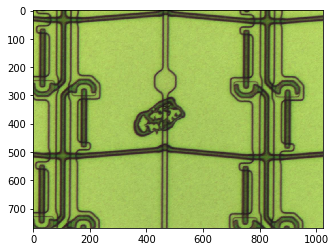

In [66]:
plt.imshow(np.squeeze(images[105][:,:,::-1]))

## Read your xml set

In [67]:
path = "C:/Users/2007058/Desktop/M2_Residue/Annotations"
xmlList = os.listdir(path)
xmls = []
for xml in xmlList:
    in_file = open(path + '/' + xml, encoding='utf-8')
    tree = ET.parse(in_file)
    xmls.append(tree)

## Define your saveName

In [68]:
saveName = []
for name in xmlList:
    temp = name.split('.')[0]
    saveName.append(temp)

In [69]:
saveName[:5]

['0001', '0002', '0003', '0004', '0005']

In [70]:
myAugmented = Augmentation(images, xmls, classes, saveName, imPath, xmlPath)

# Reflect

In [71]:
myAugmented.reflect(dim = 1)

# Plot the result

In [72]:
res = cv2.imread('test/reflect/image/0106.jpg')
orig = cv2.imread('C:/Users/2007058/Desktop/M2_Residue/JPEGImages/0106.jpg')

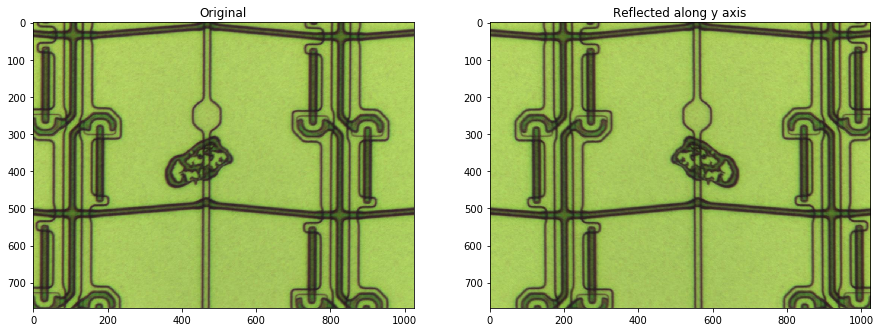

In [74]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(orig[:,:,::-1])
ax.title.set_text("Original")
ax2.imshow(res[:,:,::-1])
ax2.title.set_text("Reflected along y axis")

# Plot the bounding box on images

In [75]:
res_xml = 'test/reflect/xml/0106.xml'
orig_xml = "C:/Users/2007058/Desktop/M2_Residue/Annotations/0106.xml"

In [80]:
res_box = drawBox(res, res_xml)
orig_box = drawBox(orig, orig_xml)

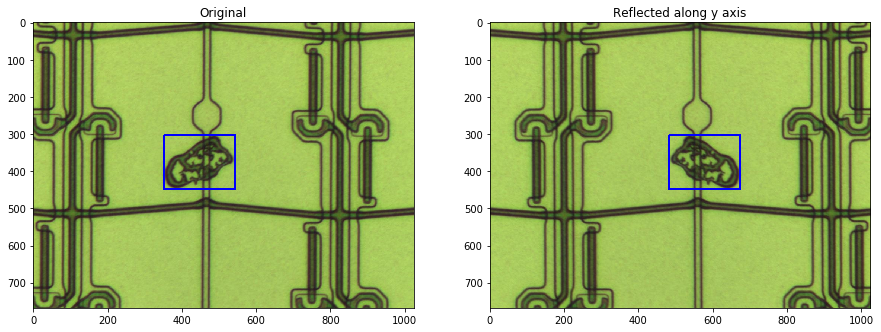

In [81]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(orig_box[:,:,::-1])
ax.title.set_text("Original")
ax2.imshow(res_box[:,:,::-1])
ax2.title.set_text("Reflected along y axis")

In [82]:
res2 = cv2.imread('test/reflect/image/0008.jpg')
orig2 = cv2.imread('C:/Users/2007058/Desktop/M2_Residue/JPEGImages/0008.jpg')
res_xml2 = 'test/reflect/xml/0008.xml'
orig_xml2 = "C:/Users/2007058/Desktop/M2_Residue/Annotations/0008.xml"

In [83]:
res_box2 = drawBox(res2, res_xml2)
orig_box2 = drawBox(orig2, orig_xml2)

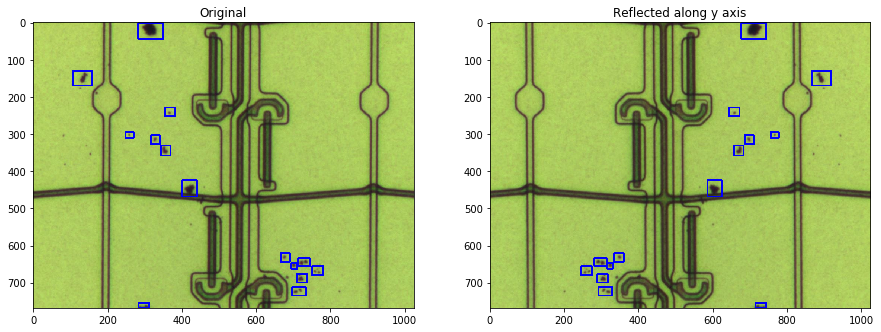

In [84]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(orig_box2[:,:,::-1])
ax.title.set_text("Original")
ax2.imshow(res_box2[:,:,::-1])
ax2.title.set_text("Reflected along y axis")

# Tutorial - translate

In [2]:
imPath = "test/translate/image" 
xmlPath = "test/translate/xml"

In [3]:
classes = ["coating_particle", "mask", "transport_particle"]

In [4]:
path = "C:/Users/2007058/Desktop/M2_Residue/JPEGImages"
imageList = os.listdir(path)
images = []
for image in imageList:
    img = cv2.imread(os.path.join(path,image))
    images.append(img)

In [5]:
path = "C:/Users/2007058/Desktop/M2_Residue/Annotations"
xmlList = os.listdir(path)
xmls = []
for xml in xmlList:
    in_file = open(path + '/' + xml, encoding='utf-8')
    tree = ET.parse(in_file)
    xmls.append(tree)

In [6]:
saveName = []
for name in xmlList:
    temp = name.split('.')[0]
    saveName.append(temp)

In [7]:
myAugmented = Augmentation(images, xmls, classes, saveName, imPath, xmlPath)

In [8]:
myAugmented.translate(50, 100)

In [9]:
res = cv2.imread('test/translate/image/0106.jpg')
orig = cv2.imread('C:/Users/2007058/Desktop/M2_Residue/JPEGImages/0106.jpg')

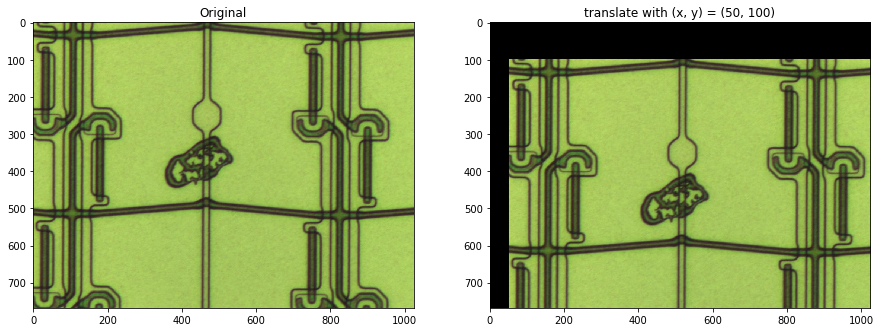

In [10]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(orig[:,:,::-1])
ax.title.set_text("Original")
ax2.imshow(res[:,:,::-1])
ax2.title.set_text("translate with (x, y) = (50, 100)")

In [11]:
res_xml = 'test/translate/xml/0106.xml'
orig_xml = "C:/Users/2007058/Desktop/M2_Residue/Annotations/0106.xml"

In [14]:
res_box = drawBox(res, res_xml)
orig_box = drawBox(orig, orig_xml)

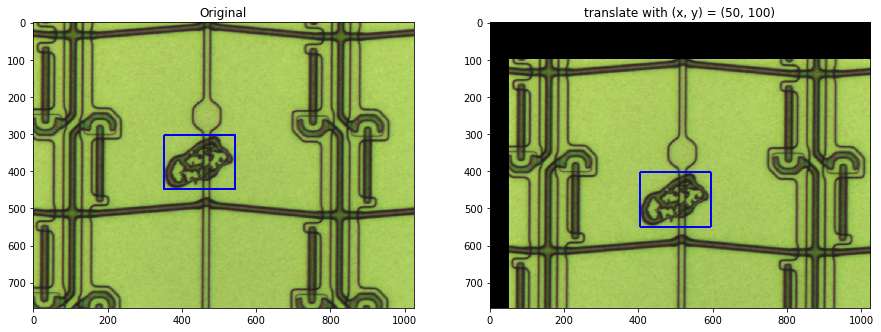

In [15]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(orig_box[:,:,::-1])
ax.title.set_text("Original")
ax2.imshow(res_box[:,:,::-1])
ax2.title.set_text("translate with (x, y) = (50, 100)")

In [16]:
res2 = cv2.imread('test/translate/image/0008.jpg')
orig2 = cv2.imread('C:/Users/2007058/Desktop/M2_Residue/JPEGImages/0008.jpg')
res_xml2 = 'test/translate/xml/0008.xml'
orig_xml2 = "C:/Users/2007058/Desktop/M2_Residue/Annotations/0008.xml"

In [17]:
res_box2 = drawBox(res2, res_xml2)
orig_box2 = drawBox(orig2, orig_xml2)

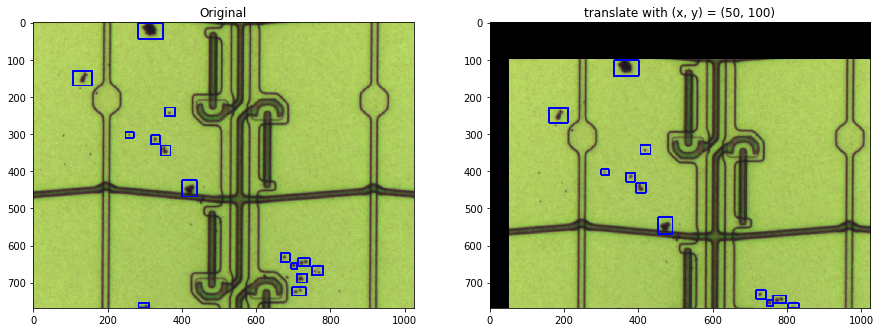

In [18]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(orig_box2[:,:,::-1])
ax.title.set_text("Original")
ax2.imshow(res_box2[:,:,::-1])
ax2.title.set_text("translate with (x, y) = (50, 100)")